In [ ]:
"""
Este script es para entrenar el modelo de desplazamiento 
con varios conjuntos de datos y probar con el restante 
"""

In [1]:
import os
import pickle
import numpy 
import random

import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot

import pandas as pd
import os

import tensorflow as tf
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import h5py



Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        data = np.genfromtxt(file_path, delimiter=',')
       
        # Obtenga el numero de peatones en el conjunto de datos actual
        #uni = np.unique(data[:,1])    
        numPeds = np.size(np.unique(data[:,1]))
     
        print("El numero de peatones en"+ directory+" es "+str(numPeds))
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
       
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

# Procesamos los datos

In [48]:
"""
Cuando se va a entrenar con varios dataset, con 4 del siguiente conjunto
"""
data_dirs = ['../data1/ucy/zara/zara02','../data1/ucy/zara/zara01',
             '../data1/ucy/univ','../data1/eth/hotel','../data1/eth/univ']

dim_image = [[720,576],[720,576],[720,576],[720,576],[640,480]]

# aqui se pone indice del dataset que va a ser el de prueba
indice_test = 4

image_size = dim_image[indice_test]

datasets = range(5)
datasets = list(datasets)
datasets.remove(indice_test)

used_data_dirs = [data_dirs[x] for x in datasets]
      
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_entrenamiento.cpkl")

name = 'pixel_pos.csv'

# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#datos tiene todos las trayectorias de todos los peatones 
data_preprocess = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,8,1)


print("El numero de muestras es de "+str(numero))

El numero de peatones en../data1/ucy/zara/zara02 es 204
El numero de peatones en../data1/ucy/zara/zara01 es 148
El numero de peatones en../data1/ucy/univ es 434
El numero de peatones en../data1/eth/hotel es 390
El numero de muestras es de 3832


In [5]:
def secuencia(seq_length_obs,data):
    tamano = int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-1
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i+seq_length_obs, :]  
            Y.append(b-a[len(a)-1,:])
    return np.array(X), np.array(Y)

# Datos para entrenamiento

In [ ]:
length_obs = 8
trainX,trainY = secuencia(length_obs,datos)

In [ ]:
trainY.shape

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))

In [ ]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

# Se diseña la red

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime

if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
model.summary()

In [ ]:
#,validation_data=(valiX,valiY)
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile( optimizer = opt,loss='logcosh',metrics=['mse'])
history1 = model.fit(trainX, trainY, epochs=80, batch_size=15, verbose=2 )
#,callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=5, verbose=1)])

In [ ]:
history_dict1 = history1.history
history_dict1.keys()

In [ ]:
acc = history1.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history1.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Guardamos los modelos

In [49]:
#model.save('lstm-ucy-univ.h5') 

In [50]:
#model.save('lstm-eth-hotel.h5')

In [51]:
#model.save('lstm-ucy-zara-zara01.h5')

In [52]:
#model.save('lstm-ucy-zara-zara02.h5')

In [53]:
#model.save('lstm-eth-univ.h5')

# Aqui se carga el modelo con el cual queremos trabajar

In [6]:
modeldxdy = load_model('lstm-eth-univ.h5')

W0324 16:08:01.552134 140291020347136 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0324 16:08:01.582977 140291020347136 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0324 16:08:01.593796 140291020347136 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0324 16:08:01.987998 140291020347136 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

# Para cargar el dataset que es el test

In [7]:

dataset_test=[indice_test]

used_data_dirs = [data_dirs[x] for x in dataset_test]
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_prueba.cpkl")

name ='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#print(used_data_dirs)
data1 = preprocess(used_data_dirs, data_file,name)

# la segunda entrada es la suma de obs + pred
test,numero = load_preprocessed(data_file,12,1)#los ultimos dos valores noimportan

El numero de peatones en../data1/eth/univ es 360


# Prediccion

In [8]:
def error_promedio(predicted_traj, true_traj, seq_length_obs):
    
    error = np.zeros(len(true_traj) - seq_length_obs)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(seq_length_obs, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-seq_length_obs] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [9]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [10]:
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [11]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en coordenadas normalizados
"""


def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i]) 
        
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade=[t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
        
    
    

In [12]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en marco pixeles
"""
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    
    trayectoria=[]
    verdadero=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([640* traj_pred[k,0],480*traj_pred[k,1]])
        #    traj_tr.append([640* Y_true[i][k,0],480*Y_true[i][k,1]])
        
        #traj_pre = np.array(traj_pre)
        #traj_tr = np.array(traj_tr)
        
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        # calcular ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre ,traj_tr,seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    #return trayectoria, verdadero

In [ ]:
sample(test, 8, 4)

In [ ]:
sample_en_pixeles(test,8,4)

# Para predecir solo las primeras posiciones observadas de cada peaton
# en el conjunto de prueba

In [15]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [46]:
"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan normalizados
"""

def sample_x_persona_normalizado(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    figure =plt.figure(figsize=(18,15))  
    grafica = figure.add_subplot(1,1,1)
    
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred, next_point),axis=0)
        
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
     
    
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        

        print("POSICIONES PREDICHAS DEL PEATON ",i+1)
        print(traj_pred[seq_length_obs:(seq_length_obs+seq_length_pred)])
        print("POSICIONES VERDADERAS  ")
        print(Y_true[i][seq_length_obs:(seq_length_obs+seq_length_pred)])
        print("EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        
        # lo observado
        grafica = plt.plot(Y_true[i][:seq_length_obs,0],Y_true[i][:seq_length_obs,1],'*--',color = color_names[cpu])
        # grand truth
        grafica = plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color = color_names[cpu])
        # predicho
        
        
        grafica = plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color = color_names[cpu])
       
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade = [t for o in todo for t in o]
    
    
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('ADE')
    print(np.mean(ade))
    #plt.savefig("4prediccion.pdf")
    plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
    plt.xlabel('Coordenada x')
    plt.ylabel('Coordenada y')
    plt.show()
    
        

('POSICIONES PREDICHAS DEL PEATON ', 1)
[[0.54811285 0.57531333]
 [0.55251406 0.54311145]
 [0.55678808 0.51242187]
 [0.56085233 0.48377515]]
POSICIONES VERDADERAS  
[[0.54479 0.57708]
 [0.54844 0.54792]
 [0.55313 0.51875]
 [0.55885 0.50139]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.009 
ERROR DE DESPLAZAMIENTO FINAL ES =0.018
('POSICIONES PREDICHAS DEL PEATON ', 2)
[[0.55056089 0.56725767]
 [0.54906807 0.53525495]
 [0.54745373 0.50497999]
 [0.54588273 0.47644115]]
POSICIONES VERDADERAS  
[[0.55625 0.56736]
 [0.55833 0.53611]
 [0.55469 0.51042]
 [0.5526  0.49375]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.011 
ERROR DE DESPLAZAMIENTO FINAL ES =0.019
('POSICIONES PREDICHAS DEL PEATON ', 3)
[[0.46897797 0.59420552]
 [0.46760488 0.62916988]
 [0.46608057 0.6627984 ]
 [0.46428631 0.694398  ]]
POSICIONES VERDADERAS  
[[0.47031 0.60625]
 [0.48229 0.66111]
 [0.48594 0.71042]
 [0.49219 0.7625 ]]
EL ERROR PROMEDIO DE LAS POSICIONES PRED

('POSICIONES PREDICHAS DEL PEATON ', 33)
[[0.41754367 0.91034778]
 [0.4169463  0.90942625]
 [0.4155957  0.90780505]
 [0.41384621 0.90550436]]
POSICIONES VERDADERAS  
[[0.41406 0.91042]
 [0.41406 0.91042]
 [0.41406 0.91042]
 [0.41406 0.91042]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.004 
ERROR DE DESPLAZAMIENTO FINAL ES =0.005
('POSICIONES PREDICHAS DEL PEATON ', 34)
[[0.43805336 0.58383519]
 [0.44855551 0.61442883]
 [0.45836211 0.64413412]
 [0.46779272 0.67224855]]
POSICIONES VERDADERAS  
[[0.43437 0.60208]
 [0.44375 0.65069]
 [0.45208 0.7    ]
 [0.46094 0.75417]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.048 
ERROR DE DESPLAZAMIENTO FINAL ES =0.082
('POSICIONES PREDICHAS DEL PEATON ', 35)
[[0.45694565 0.57602653]
 [0.46772551 0.60693624]
 [0.47791857 0.63682931]
 [0.48771311 0.66494337]]
POSICIONES VERDADERAS  
[[0.45312 0.59375]
 [0.4625  0.64236]
 [0.47083 0.69167]
 [0.47969 0.74583]]
EL ERROR PROMEDIO DE LAS POSICIONES P

[[0.45789449 0.48181334]
 [0.46990529 0.51045239]
 [0.48087797 0.53966778]
 [0.4913041  0.56804354]]
POSICIONES VERDADERAS  
[[0.4474  0.49826]
 [0.4513  0.54687]
 [0.45781 0.59375]
 [0.46328 0.64688]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.051 
ERROR DE DESPLAZAMIENTO FINAL ES =0.084
('POSICIONES PREDICHAS DEL PEATON ', 70)
[[0.4409671  0.47711472]
 [0.45749637 0.50352015]
 [0.47288773 0.53012433]
 [0.4876718  0.55607161]]
POSICIONES VERDADERAS  
[[0.43047 0.49479]
 [0.44167 0.54028]
 [0.45208 0.58715]
 [0.46172 0.63646]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.051 
ERROR DE DESPLAZAMIENTO FINAL ES =0.084
('POSICIONES PREDICHAS DEL PEATON ', 71)
[[0.56840242 0.43768838]
 [0.57332527 0.40420521]
 [0.57804134 0.37275784]
 [0.58265041 0.34350033]]
POSICIONES VERDADERAS  
[[0.57214 0.42951]
 [0.57813 0.39063]
 [0.58359 0.35278]
 [0.59401 0.31806]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.018 
E

('POSICIONES PREDICHAS DEL PEATON ', 105)
[[0.42490535 0.4585196 ]
 [0.41411796 0.42477541]
 [0.40332651 0.3930864 ]
 [0.39280486 0.36409836]]
POSICIONES VERDADERAS  
[[0.43125 0.44896]
 [0.41979 0.40833]
 [0.41198 0.36667]
 [0.40469 0.33021]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.023 
ERROR DE DESPLAZAMIENTO FINAL ES =0.036
('POSICIONES PREDICHAS DEL PEATON ', 106)
[[0.42084861 0.5361571 ]
 [0.43245241 0.56800564]
 [0.44325408 0.59928144]
 [0.45361594 0.62894993]]
POSICIONES VERDADERAS  
[[0.41745 0.5566 ]
 [0.42786 0.61042]
 [0.44375 0.6625 ]
 [0.46276 0.71563]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.053 
ERROR DE DESPLAZAMIENTO FINAL ES =0.087
('POSICIONES PREDICHAS DEL PEATON ', 107)
[[0.52701024 0.43954141]
 [0.52620562 0.39528565]
 [0.5252971  0.35331843]
 [0.5244609  0.31415026]]
POSICIONES VERDADERAS  
[[0.52813 0.43264]
 [0.52943 0.38229]
 [0.53281 0.33438]
 [0.53594 0.28472]]
EL ERROR PROMEDIO DE LAS POSICIONE

('POSICIONES PREDICHAS DEL PEATON ', 136)
[[0.58162346 0.52095426]
 [0.58462521 0.48358647]
 [0.58696589 0.44777897]
 [0.58924354 0.41383221]]
POSICIONES VERDADERAS  
[[0.58177 0.51424]
 [0.58958 0.47083]
 [0.59531 0.42917]
 [0.60208 0.3875 ]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.018 
ERROR DE DESPLAZAMIENTO FINAL ES =0.029
('POSICIONES PREDICHAS DEL PEATON ', 137)
[[0.40265583 0.59660554]
 [0.39315149 0.56682427]
 [0.38431704 0.5383828 ]
 [0.37570654 0.51204257]]
POSICIONES VERDADERAS  
[[0.40469 0.58194]
 [0.39531 0.52917]
 [0.39349 0.49618]
 [0.39089 0.45625]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.038 
ERROR DE DESPLAZAMIENTO FINAL ES =0.058
('POSICIONES PREDICHAS DEL PEATON ', 138)
[[0.61373894 0.44261866]
 [0.61739966 0.40175664]
 [0.61988115 0.36299067]
 [0.62185079 0.32672978]]
POSICIONES VERDADERAS  
[[0.58385 0.4434 ]
 [0.56563 0.39653]
 [0.55391 0.34792]
 [0.54479 0.29514]]
EL ERROR PROMEDIO DE LAS POSICIONE

('POSICIONES PREDICHAS DEL PEATON ', 170)
[[0.47712491 0.54981708]
 [0.47827311 0.58044488]
 [0.47919822 0.60978613]
 [0.47992554 0.63734928]]
POSICIONES VERDADERAS  
[[0.47995 0.55799]
 [0.48125 0.59618]
 [0.48438 0.63125]
 [0.4862  0.6684 ]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.020 
ERROR DE DESPLAZAMIENTO FINAL ES =0.032
('POSICIONES PREDICHAS DEL PEATON ', 171)
[[0.54269649 0.65965152]
 [0.53505349 0.70300589]
 [0.52653865 0.74461993]
 [0.517273   0.78358223]]
POSICIONES VERDADERAS  
[[0.54115 0.67708]
 [0.53073 0.74132]
 [0.51797 0.82292]
 [0.51172 0.89722]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.062 
ERROR DE DESPLAZAMIENTO FINAL ES =0.114
('POSICIONES PREDICHAS DEL PEATON ', 172)
[[0.5613495  0.68379459]
 [0.55184579 0.7282629 ]
 [0.54130384 0.77092897]
 [0.52988064 0.81076875]]
POSICIONES VERDADERAS  
[[0.56042 0.7    ]
 [0.55391 0.7625 ]
 [0.55391 0.83333]
 [0.54818 0.90243]]
EL ERROR PROMEDIO DE LAS POSICIONE

('POSICIONES PREDICHAS DEL PEATON ', 203)
[[0.49244869 0.65276252]
 [0.48639954 0.62841118]
 [0.48019123 0.60545538]
 [0.47394057 0.58418301]]
POSICIONES VERDADERAS  
[[0.49974 0.64896]
 [0.50859 0.62187]
 [0.52005 0.59201]
 [0.52135 0.56597]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.031 
ERROR DE DESPLAZAMIENTO FINAL ES =0.051
('POSICIONES PREDICHAS DEL PEATON ', 204)
[[0.58375807 0.51942608]
 [0.59658438 0.55556109]
 [0.60929807 0.59084199]
 [0.62162976 0.624657  ]]
POSICIONES VERDADERAS  
[[0.58021 0.54063]
 [0.58828 0.59479]
 [0.59089 0.64722]
 [0.59349 0.69931]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.050 
ERROR DE DESPLAZAMIENTO FINAL ES =0.080
('POSICIONES PREDICHAS DEL PEATON ', 205)
[[0.44295791 0.62545205]
 [0.42795073 0.60103232]
 [0.4114477  0.57723814]
 [0.39448868 0.55451623]]
POSICIONES VERDADERAS  
[[0.44089 0.59687]
 [0.42786 0.54479]
 [0.41797 0.49792]
 [0.40859 0.45174]]
EL ERROR PROMEDIO DE LAS POSICIONE

('POSICIONES PREDICHAS DEL PEATON ', 235)
[[0.48433479 0.49747155]
 [0.48558579 0.53337347]
 [0.48644099 0.56699994]
 [0.48689511 0.59784316]]
POSICIONES VERDADERAS  
[[0.48125 0.50903]
 [0.48125 0.5559 ]
 [0.48125 0.6    ]
 [0.48281 0.64826]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.030 
ERROR DE DESPLAZAMIENTO FINAL ES =0.051
('POSICIONES PREDICHAS DEL PEATON ', 236)
[[0.50830634 0.44019108]
 [0.50964964 0.47222546]
 [0.51095242 0.50350618]
 [0.51212035 0.53327454]]
POSICIONES VERDADERAS  
[[0.51094 0.45208]
 [0.51094 0.49375]
 [0.51172 0.53958]
 [0.5125  0.58854]]
EL ERROR PROMEDIO DE LAS POSICIONES PREDICHAS DE LA TRAYECTORIA  ES = 0.031 
ERROR DE DESPLAZAMIENTO FINAL ES =0.055
('POSICIONES PREDICHAS DEL PEATON ', 237)
[[0.52117455 0.46978131]
 [0.52150173 0.50279203]
 [0.52167212 0.53560071]
 [0.52161778 0.56736829]]
POSICIONES VERDADERAS  
[[0.52344 0.47917]
 [0.52344 0.52083]
 [0.52422 0.56562]
 [0.525   0.61562]]
EL ERROR PROMEDIO DE LAS POSICIONE

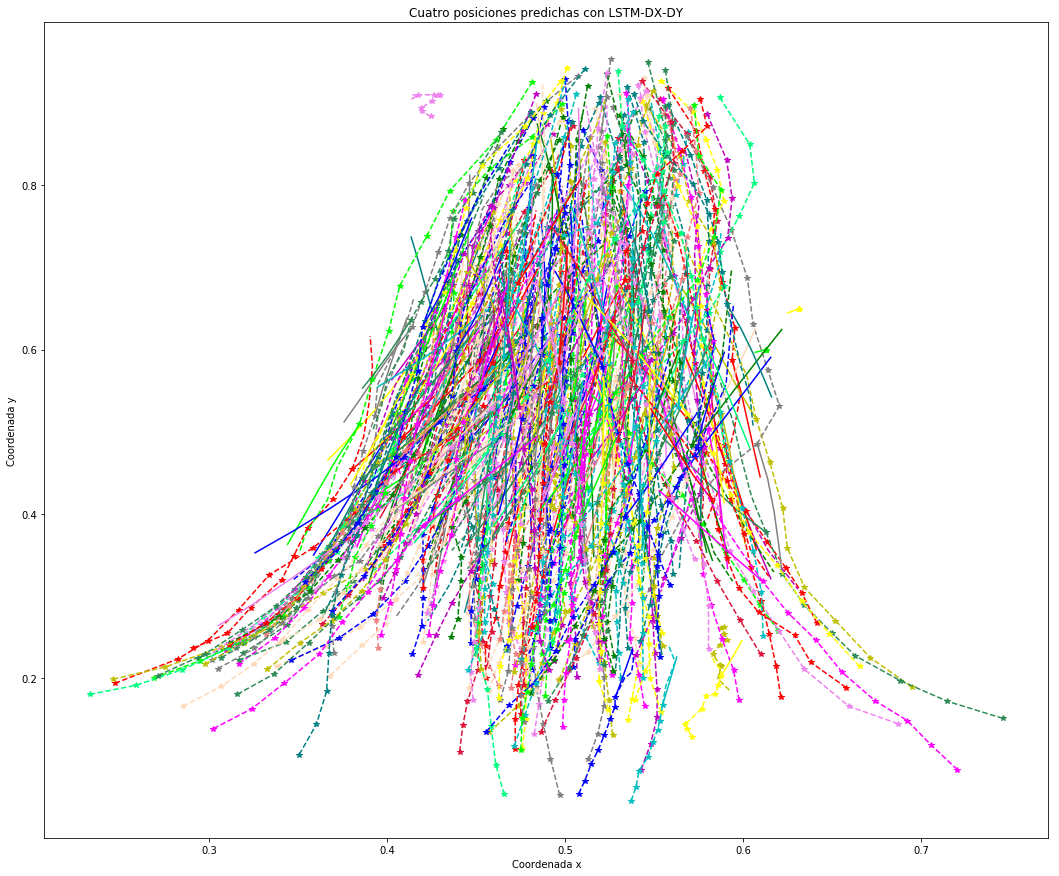

In [47]:
sample_x_persona_normalizado(test,8,4)


In [56]:
"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan en marco pixel
"""



def sample_x_persona(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
    
        traj_pre = []
        traj_tr = []
        for k in range(len(traj_pred)):
            traj_pre.append([image_size[0]* traj_pred[k,0],image_size[1]*traj_pred[k,1]])
            traj_tr.append([image_size[0]* Y_true[i][k,0],image_size[1]*Y_true[i][k,1]])
        
        traj_pre=np.array(traj_pre)
        traj_tr=np.array(traj_tr)
        error_prom = error_promedio(traj_pre , traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre , traj_tr)
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre)
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr)
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        #lo observado
        predicha = plt.plot(traj_tr[:seq_length_obs,0],traj_tr[:seq_length_obs,1],'*--',color= color_names[cpu]) 
        # grand truth
        predicha = plt.plot(traj_tr[seq_length_obs-1:,0],traj_tr[seq_length_obs-1:,1],'--',color= color_names[cpu])
        # lo predicho
        predicha = plt.plot(traj_pre[seq_length_obs-1:,0],traj_pre[seq_length_obs-1:,1],'-',color=color_names[cpu])
        
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    
    ade=[t for o in todo for t in o]
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print("Error ADE")
    print(np.mean(ade))
    plt.savefig("trayectoriasdxdy.jpg")
    plt.show()
    
        
    
    

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[336.3328     457.6656    ]
 [332.9984     416.0016    ]
 [333.3312     396.9984    ]
 [336.3328     369.6672    ]
 [342.0032     351.        ]
 [343.3344     330.3312    ]
 [346.336      311.3328    ]
 [348.         293.0016    ]
 [350.79222369 276.15040013]
 [353.60900092 260.69349477]
 [356.34437132 245.96249977]
 [358.94548941 232.21207121]]
TRAYECTORIA VERDADERA  
[[336.3328 457.6656]
 [332.9984 416.0016]
 [333.3312 396.9984]
 [336.3328 369.6672]
 [342.0032 351.    ]
 [343.3344 330.3312]
 [346.336  311.3328]
 [348.     293.0016]
 [348.6656 276.9984]
 [351.0016 263.0016]
 [354.0032 249.    ]
 [357.664  240.6672]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 4.540 
ERROR DE DESPLAZAMIENTO FINAL ES =8.552
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[355.6672     426.        ]
 [359.0016     411.        ]
 [359.3344     387.3312    ]
 [357.3312     366.3312    ]
 [356.9984     345.        ]
 [355.6672     326.3328    ]
 [354.336      306.9984

('TRAYECTORIA PREDICHA DEL PEATON ', 18)
[[319.6672     356.3328    ]
 [318.336      333.3312    ]
 [317.9968     309.9984    ]
 [313.3312     286.6656    ]
 [313.3312     264.9984    ]
 [311.0016     245.0016    ]
 [307.3344     225.        ]
 [304.3328     205.3344    ]
 [302.28133985 189.50379497]
 [300.1080794  174.49264413]
 [297.93933222 160.504596  ]
 [295.91104576 147.62662298]]
TRAYECTORIA VERDADERA  
[[319.6672 356.3328]
 [318.336  333.3312]
 [317.9968 309.9984]
 [313.3312 286.6656]
 [313.3312 264.9984]
 [311.0016 245.0016]
 [307.3344 225.    ]
 [304.3328 205.3344]
 [301.9968 186.9984]
 [301.3312 167.0016]
 [301.3312 148.3344]
 [300.9984 129.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.514 
ERROR DE DESPLAZAMIENTO FINAL ES =19.309
('TRAYECTORIA PREDICHA DEL PEATON ', 19)
[[255.3344     209.0016    ]
 [263.3344     224.3328    ]
 [264.         236.0016    ]
 [268.6656     252.        ]
 [271.6672     268.6656    ]
 [274.0032     288.        ]
 [278.336      307.

('TRAYECTORIA PREDICHA DEL PEATON ', 36)
[[318.6688     431.6688    ]
 [308.         412.3344    ]
 [292.9984     393.9984    ]
 [279.6672     369.3312    ]
 [278.336      342.6672    ]
 [280.         321.        ]
 [279.3344     298.3344    ]
 [278.0032     275.6688    ]
 [273.74390811 259.59010494]
 [271.04149372 243.67110682]
 [269.21457917 228.46964789]
 [267.59679348 214.49510289]]
TRAYECTORIA VERDADERA  
[[318.6688 431.6688]
 [308.     412.3344]
 [292.9984 393.9984]
 [279.6672 369.3312]
 [278.336  342.6672]
 [280.     321.    ]
 [279.3344 298.3344]
 [278.0032 275.6688]
 [275.0016 254.0016]
 [269.9968 231.3312]
 [264.9984 211.6656]
 [263.0016 195.9984]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 13.624 
ERROR DE DESPLAZAMIENTO FINAL ES =19.059
('TRAYECTORIA PREDICHA DEL PEATON ', 37)
[[348.3328     447.        ]
 [350.0032     417.3312    ]
 [344.9984     389.0016    ]
 [337.3312     362.0016    ]
 [328.9984     336.9984    ]
 [318.0032     312.9984    ]
 [313.3312     288.

('TRAYECTORIA PREDICHA DEL PEATON ', 57)
[[316.         105.9984    ]
 [318.6688     126.9984    ]
 [317.8304     147.8352    ]
 [319.5008     168.9984    ]
 [320.6656     190.3344    ]
 [324.832      212.832     ]
 [325.9968     236.0016    ]
 [323.3344     259.1664    ]
 [324.43798357 276.78275542]
 [325.0347274  294.19019537]
 [325.21245951 310.97869234]
 [324.91650337 326.82655649]]
TRAYECTORIA VERDADERA  
[[316.     105.9984]
 [318.6688 126.9984]
 [317.8304 147.8352]
 [319.5008 168.9984]
 [320.6656 190.3344]
 [324.832  212.832 ]
 [325.9968 236.0016]
 [323.3344 259.1664]
 [325.8304 282.4992]
 [322.5024 305.5008]
 [321.8304 329.5008]
 [317.664  353.6688]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 16.027 
ERROR DE DESPLAZAMIENTO FINAL ES =27.805
('TRAYECTORIA PREDICHA DEL PEATON ', 58)
[[337.4976     108.9984    ]
 [335.168      129.        ]
 [336.832      149.832     ]
 [339.5008     171.        ]
 [340.1664     191.1648    ]
 [340.9984     212.832     ]
 [342.0032     236.

('TRAYECTORIA PREDICHA DEL PEATON ', 74)
[[292.         103.1664    ]
 [293.4976     123.        ]
 [292.832      143.832     ]
 [294.5024     162.9984    ]
 [295.5008     184.5024    ]
 [295.6672     206.0016    ]
 [293.9968     226.8336    ]
 [294.5024     249.9984    ]
 [294.78760703 266.46984198]
 [294.79493542 282.78143862]
 [294.59125086 298.51323822]
 [294.12942394 313.37995657]]
TRAYECTORIA VERDADERA  
[[292.     103.1664]
 [293.4976 123.    ]
 [292.832  143.832 ]
 [294.5024 162.9984]
 [295.5008 184.5024]
 [295.6672 206.0016]
 [293.9968 226.8336]
 [294.5024 249.9984]
 [295.0016 273.4992]
 [295.8336 299.3328]
 [296.     324.4992]
 [297.1648 349.6656]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 21.513 
ERROR DE DESPLAZAMIENTO FINAL ES =36.412
('TRAYECTORIA PREDICHA DEL PEATON ', 75)
[[328.3328      48.4992    ]
 [331.6672      63.4992    ]
 [333.9968      80.0016    ]
 [334.0032      96.8352    ]
 [332.3328     116.0016    ]
 [332.9984     131.5008    ]
 [329.664      147.

('TRAYECTORIA PREDICHA DEL PEATON ', 88)
[[148.9984      86.5008    ]
 [165.664       91.8336    ]
 [182.336      101.0016    ]
 [199.0016     113.5008    ]
 [211.3344     131.5008    ]
 [223.0016     145.6656    ]
 [231.0016     165.9984    ]
 [240.         184.8336    ]
 [252.52005458 194.92357589]
 [264.25719976 206.24338396]
 [275.57843566 217.8935454 ]
 [286.78020954 229.221536  ]]
TRAYECTORIA VERDADERA  
[[148.9984  86.5008]
 [165.664   91.8336]
 [182.336  101.0016]
 [199.0016 113.5008]
 [211.3344 131.5008]
 [223.0016 145.6656]
 [231.0016 165.9984]
 [240.     184.8336]
 [246.6688 204.    ]
 [256.     224.5008]
 [262.8352 246.6672]
 [271.168  269.1648]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 26.298 
ERROR DE DESPLAZAMIENTO FINAL ES =42.886
('TRAYECTORIA PREDICHA DEL PEATON ', 89)
[[439.6672      69.3312    ]
 [421.9968      79.5024    ]
 [406.0032     101.1648    ]
 [396.832      123.6672    ]
 [387.5008     147.        ]
 [379.168      170.5008    ]
 [375.0016     195.

('TRAYECTORIA PREDICHA DEL PEATON ', 100)
[[300.4992      90.        ]
 [302.1696     109.8336    ]
 [299.6672     129.8352    ]
 [300.4992     152.0016    ]
 [303.8336     176.1648    ]
 [309.664      199.5024    ]
 [312.9984     224.5008    ]
 [315.0016     251.6688    ]
 [317.5613465  270.23010838]
 [320.28998158 288.9958905 ]
 [322.98959753 307.31158007]
 [325.3446295  324.66450322]]
TRAYECTORIA VERDADERA  
[[300.4992  90.    ]
 [302.1696 109.8336]
 [299.6672 129.8352]
 [300.4992 152.0016]
 [303.8336 176.1648]
 [309.664  199.5024]
 [312.9984 224.5008]
 [315.0016 251.6688]
 [315.8336 278.3328]
 [317.4976 305.5008]
 [320.1664 333.8352]
 [321.8304 363.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 22.548 
ERROR DE DESPLAZAMIENTO FINAL ES =38.496
('TRAYECTORIA PREDICHA DEL PEATON ', 101)
[[336.9984      63.        ]
 [335.6672      83.0016    ]
 [334.0032     105.4992    ]
 [329.9968     126.4992    ]
 [328.3328     153.        ]
 [329.9968     173.832     ]
 [332.         19

('TRAYECTORIA PREDICHA DEL PEATON ', 112)
[[201.664      113.832     ]
 [212.         126.9984    ]
 [221.664      142.8336    ]
 [230.8352     159.4992    ]
 [240.         176.5008    ]
 [250.1696     194.5008    ]
 [260.9984     211.1664    ]
 [271.0016     228.        ]
 [281.25088451 240.53385276]
 [291.60729882 253.18349111]
 [302.02688095 265.45821744]
 [312.44079587 277.08547997]]
TRAYECTORIA VERDADERA  
[[201.664  113.832 ]
 [212.     126.9984]
 [221.664  142.8336]
 [230.8352 159.4992]
 [240.     176.5008]
 [250.1696 194.5008]
 [260.9984 211.1664]
 [271.0016 228.    ]
 [279.8336 246.8352]
 [288.1664 266.832 ]
 [292.4992 291.    ]
 [297.4976 314.6688]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 22.060 
ERROR DE DESPLAZAMIENTO FINAL ES =40.445
('TRAYECTORIA PREDICHA DEL PEATON ', 113)
[[377.1648     126.        ]
 [376.         125.5008    ]
 [377.1648     121.6656    ]
 [377.9968     118.3344    ]
 [375.5008     115.4976    ]
 [372.9984     110.3328    ]
 [375.5008     10

('TRAYECTORIA PREDICHA DEL PEATON ', 123)
[[300.9984     123.4992    ]
 [299.168      143.0016    ]
 [300.         162.168     ]
 [299.0016     184.5024    ]
 [297.1648     207.9984    ]
 [298.8352     228.        ]
 [300.         249.4992    ]
 [301.1648     271.3344    ]
 [301.15840681 288.11250431]
 [301.25634201 304.5557974 ]
 [301.2575484  320.23285848]
 [301.1155165  334.78402746]]
TRAYECTORIA VERDADERA  
[[300.9984 123.4992]
 [299.168  143.0016]
 [300.     162.168 ]
 [299.0016 184.5024]
 [297.1648 207.9984]
 [298.8352 228.    ]
 [300.     249.4992]
 [301.1648 271.3344]
 [303.6672 294.6672]
 [305.4976 319.5024]
 [308.1664 343.5024]
 [311.5008 368.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 20.527 
ERROR DE DESPLAZAMIENTO FINAL ES =35.280
('TRAYECTORIA PREDICHA DEL PEATON ', 124)
[[320.4992     117.9984    ]
 [323.168      142.3344    ]
 [324.832      166.4976    ]
 [325.4976     192.        ]
 [326.1696     218.6688    ]
 [327.8336     245.3328    ]
 [329.9968     27

('TRAYECTORIA PREDICHA DEL PEATON ', 138)
[[363.6672     412.8336    ]
 [372.9984     383.0016    ]
 [379.6672     358.1664    ]
 [385.4976     329.832     ]
 [387.5008     303.        ]
 [392.832      276.        ]
 [396.9984     255.168     ]
 [388.9984     233.0016    ]
 [392.7929199  212.45695541]
 [395.13577941 192.84318754]
 [396.72393563 174.23551986]
 [397.98450592 156.83029363]]
TRAYECTORIA VERDADERA  
[[363.6672 412.8336]
 [372.9984 383.0016]
 [379.6672 358.1664]
 [385.4976 329.832 ]
 [387.5008 303.    ]
 [392.832  276.    ]
 [396.9984 255.168 ]
 [388.9984 233.0016]
 [373.664  212.832 ]
 [362.0032 190.3344]
 [354.5024 167.0016]
 [348.6656 141.6672]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 36.699 
ERROR DE DESPLAZAMIENTO FINAL ES =51.597
('TRAYECTORIA PREDICHA DEL PEATON ', 139)
[[324.         437.5008    ]
 [319.6672     412.5024    ]
 [316.3328     390.        ]
 [312.         367.5024    ]
 [306.336      344.832     ]
 [301.3312     322.3344    ]
 [296.9984     30

('TRAYECTORIA PREDICHA DEL PEATON ', 152)
[[348.4992     381.        ]
 [343.0016     354.4992    ]
 [332.9984     329.5008    ]
 [319.5008     306.4992    ]
 [305.3312     285.        ]
 [290.336      264.9984    ]
 [274.5024     245.5008    ]
 [261.8304     225.3312    ]
 [248.66048432 209.48024952]
 [235.06934739 194.84368616]
 [221.59029819 181.44087636]
 [208.45019795 169.27286172]]
TRAYECTORIA VERDADERA  
[[348.4992 381.    ]
 [343.0016 354.4992]
 [332.9984 329.5008]
 [319.5008 306.4992]
 [305.3312 285.    ]
 [290.336  264.9984]
 [274.5024 245.5008]
 [261.8304 225.3312]
 [253.4976 207.8352]
 [246.0032 189.4992]
 [237.8304 169.5024]
 [227.0016 153.6672]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 15.419 
ERROR DE DESPLAZAMIENTO FINAL ES =24.242
('TRAYECTORIA PREDICHA DEL PEATON ', 153)
[[365.4976      61.4976    ]
 [363.8336      66.4992    ]
 [363.0016      69.        ]
 [368.9984      78.        ]
 [370.6688      85.3344    ]
 [373.9968      87.        ]
 [375.0016      9

('TRAYECTORIA PREDICHA DEL PEATON ', 165)
[[356.         430.4976    ]
 [356.         401.1648    ]
 [354.336      372.        ]
 [351.5008     344.0016    ]
 [346.1696     317.6688    ]
 [334.5024     291.        ]
 [324.9984     266.0016    ]
 [317.664      243.        ]
 [311.43729528 222.72988129]
 [304.30646202 203.50893724]
 [296.89274212 185.54841149]
 [289.57535883 168.94117105]]
TRAYECTORIA VERDADERA  
[[356.     430.4976]
 [356.     401.1648]
 [354.336  372.    ]
 [351.5008 344.0016]
 [346.1696 317.6688]
 [334.5024 291.    ]
 [324.9984 266.0016]
 [317.664  243.    ]
 [312.6656 222.168 ]
 [304.     200.5008]
 [294.8352 179.1648]
 [284.832  159.9984]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 5.301 
ERROR DE DESPLAZAMIENTO FINAL ES =10.123
('TRAYECTORIA PREDICHA DEL PEATON ', 166)
[[335.0016     435.9984    ]
 [332.         406.4976    ]
 [333.664      380.6688    ]
 [336.9984     357.        ]
 [339.0016     333.9984    ]
 [339.8336     313.1664    ]
 [340.9984     291

('TRAYECTORIA PREDICHA DEL PEATON ', 176)
[[304.1664     185.832     ]
 [303.0016     207.        ]
 [301.664      225.9984    ]
 [300.         247.6656    ]
 [300.         268.5024    ]
 [304.1664     293.0016    ]
 [304.1664     312.168     ]
 [307.5008     332.0016    ]
 [307.51981865 348.01025006]
 [307.81741391 363.34427449]
 [308.12113296 377.67203334]
 [308.24041258 390.68664167]]
TRAYECTORIA VERDADERA  
[[304.1664 185.832 ]
 [303.0016 207.    ]
 [301.664  225.9984]
 [300.     247.6656]
 [300.     268.5024]
 [304.1664 293.0016]
 [304.1664 312.168 ]
 [307.5008 332.0016]
 [311.3344 349.5024]
 [321.3312 366.9984]
 [329.4976 387.9984]
 [335.0016 408.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 18.427 
ERROR DE DESPLAZAMIENTO FINAL ES =31.873
('TRAYECTORIA PREDICHA DEL PEATON ', 177)
[[316.         195.        ]
 [316.4992     214.4976    ]
 [316.1664     233.1648    ]
 [316.9984     254.832     ]
 [315.5008     276.9984    ]
 [314.336      303.3312    ]
 [317.664      32

('TRAYECTORIA PREDICHA DEL PEATON ', 188)
[[366.336      431.1648    ]
 [368.         401.5008    ]
 [376.         381.4992    ]
 [373.4976     354.        ]
 [367.5008     329.0016    ]
 [357.1648     306.8352    ]
 [347.168      284.3328    ]
 [337.9968     262.5024    ]
 [332.70043438 243.86352034]
 [325.79774326 226.09455796]
 [318.15528577 209.23461052]
 [310.57067221 193.62842055]]
TRAYECTORIA VERDADERA  
[[366.336  431.1648]
 [368.     401.5008]
 [376.     381.4992]
 [373.4976 354.    ]
 [367.5008 329.0016]
 [357.1648 306.8352]
 [347.168  284.3328]
 [337.9968 262.5024]
 [329.3312 239.832 ]
 [323.5008 220.6656]
 [324.     204.4992]
 [318.8352 185.6688]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 7.536 
ERROR DE DESPLAZAMIENTO FINAL ES =11.474
('TRAYECTORIA PREDICHA DEL PEATON ', 189)
[[356.         451.5024    ]
 [358.8352     419.832     ]
 [357.1648     388.1664    ]
 [353.4976     355.4976    ]
 [345.8304     323.3328    ]
 [334.1696     297.4992    ]
 [323.0016     273

('TRAYECTORIA PREDICHA DEL PEATON ', 199)
[[347.5008     444.9984    ]
 [358.1696     421.1664    ]
 [359.0016     396.9984    ]
 [353.4976     372.        ]
 [348.         347.1648    ]
 [342.1696     324.6672    ]
 [336.9984     304.5024    ]
 [332.6656     282.9984    ]
 [329.01280445 265.19854215]
 [324.46371001 248.16496995]
 [319.8429243  232.11531785]
 [315.4075138  217.1761879 ]]
TRAYECTORIA VERDADERA  
[[347.5008 444.9984]
 [358.1696 421.1664]
 [359.0016 396.9984]
 [353.4976 372.    ]
 [348.     347.1648]
 [342.1696 324.6672]
 [336.9984 304.5024]
 [332.6656 282.9984]
 [330.1696 261.3312]
 [326.0032 239.5008]
 [322.5024 218.0016]
 [318.336  198.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 11.649 
ERROR DE DESPLAZAMIENTO FINAL ES =19.399
('TRAYECTORIA PREDICHA DEL PEATON ', 200)
[[351.5008     438.9984    ]
 [347.6672     421.8336    ]
 [345.9968     407.6688    ]
 [343.5008     393.9984    ]
 [339.5008     381.        ]
 [341.1648     368.5008    ]
 [336.4992     35

('TRAYECTORIA PREDICHA DEL PEATON ', 219)
[[332.1664     107.0016    ]
 [332.         117.        ]
 [331.6672     128.1648    ]
 [329.1648     139.8336    ]
 [327.0016     152.0016    ]
 [326.0032     165.168     ]
 [325.1648     178.4976    ]
 [326.5024     192.        ]
 [325.59598561 202.38530678]
 [324.87576957 212.9174037 ]
 [324.296959   223.28345758]
 [323.80556401 233.26523316]]
TRAYECTORIA VERDADERA  
[[332.1664 107.0016]
 [332.     117.    ]
 [331.6672 128.1648]
 [329.1648 139.8336]
 [327.0016 152.0016]
 [326.0032 165.168 ]
 [325.1648 178.4976]
 [326.5024 192.    ]
 [326.8352 206.832 ]
 [326.8352 222.6672]
 [325.9968 237.    ]
 [325.8304 250.4976]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 11.433 
ERROR DE DESPLAZAMIENTO FINAL ES =17.351
('TRAYECTORIA PREDICHA DEL PEATON ', 220)
[[294.1696     368.3328    ]
 [288.4992     348.        ]
 [284.6656     333.4992    ]
 [281.3312     317.6688    ]
 [282.5024     302.0016    ]
 [283.3344     284.0016    ]
 [284.9984     26

('TRAYECTORIA PREDICHA DEL PEATON ', 230)
[[195.0016     101.5008    ]
 [208.1664     113.3328    ]
 [218.1696     128.3328    ]
 [227.5008     143.0016    ]
 [236.9984     155.5008    ]
 [246.1696     164.6688    ]
 [252.4992     179.0016    ]
 [258.6688     194.5008    ]
 [267.78567016 204.21789162]
 [276.36025727 214.03283738]
 [284.74081695 223.64436798]
 [293.06439937 232.94879817]]
TRAYECTORIA VERDADERA  
[[195.0016 101.5008]
 [208.1664 113.3328]
 [218.1696 128.3328]
 [227.5008 143.0016]
 [236.9984 155.5008]
 [246.1696 164.6688]
 [252.4992 179.0016]
 [258.6688 194.5008]
 [264.4992 210.3312]
 [271.0016 228.    ]
 [276.832  245.832 ]
 [283.5008 264.9984]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 19.725 
ERROR DE DESPLAZAMIENTO FINAL ES =33.446
('TRAYECTORIA PREDICHA DEL PEATON ', 231)
[[311.3344      64.6656    ]
 [316.3328      83.0016    ]
 [324.         108.        ]
 [330.5024     133.5024    ]
 [334.6688     159.3312    ]
 [336.         180.4992    ]
 [337.3312     20

('TRAYECTORIA PREDICHA DEL PEATON ', 241)
[[309.664      379.3344    ]
 [305.4976     356.5008    ]
 [300.832      332.832     ]
 [299.168      311.1648    ]
 [296.9984     288.9984    ]
 [295.8336     269.0016    ]
 [295.0016     249.        ]
 [293.4976     229.5024    ]
 [291.7321742  214.06669124]
 [290.35624091 199.37788828]
 [289.21807234 185.65510078]
 [288.18897907 172.99045904]]
TRAYECTORIA VERDADERA  
[[309.664  379.3344]
 [305.4976 356.5008]
 [300.832  332.832 ]
 [299.168  311.1648]
 [296.9984 288.9984]
 [295.8336 269.0016]
 [295.0016 249.    ]
 [293.4976 229.5024]
 [291.5008 211.3344]
 [285.664  194.6688]
 [279.5008 179.0016]
 [271.5008 162.4992]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.220 
ERROR DE DESPLAZAMIENTO FINAL ES =19.712
('TRAYECTORIA PREDICHA DEL PEATON ', 242)
[[226.5024     152.3328    ]
 [237.3312     170.6688    ]
 [245.4976     186.4992    ]
 [251.6672     204.6672    ]
 [259.168      225.4992    ]
 [262.5024     251.5008    ]
 [267.0016     27

('TRAYECTORIA PREDICHA DEL PEATON ', 253)
[[342.5024     434.5008    ]
 [343.3344     398.0016    ]
 [344.9984     368.832     ]
 [344.         341.5008    ]
 [344.         314.5008    ]
 [344.832      289.4976    ]
 [348.         266.5008    ]
 [345.4976     243.6672    ]
 [346.39322058 223.43913832]
 [347.10182325 204.49403444]
 [347.75557892 186.66197756]
 [348.46211688 169.99261716]]
TRAYECTORIA VERDADERA  
[[342.5024 434.5008]
 [343.3344 398.0016]
 [344.9984 368.832 ]
 [344.     341.5008]
 [344.     314.5008]
 [344.832  289.4976]
 [348.     266.5008]
 [345.4976 243.6672]
 [341.3312 220.3344]
 [332.     200.5008]
 [322.5024 181.1664]
 [310.0032 162.8352]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 21.631 
ERROR DE DESPLAZAMIENTO FINAL ES =39.119
('TRAYECTORIA PREDICHA DEL PEATON ', 254)
[[420.9984      90.4992    ]
 [408.3328     105.168     ]
 [402.5024     120.9984    ]
 [389.4976     134.5008    ]
 [382.336      148.6656    ]
 [378.1696     166.1664    ]
 [375.0016     18

('TRAYECTORIA PREDICHA DEL PEATON ', 264)
[[332.4992     101.5008    ]
 [330.6688     122.832     ]
 [328.1664     143.6688    ]
 [327.0016     165.        ]
 [325.8304     186.3312    ]
 [324.9984     210.4992    ]
 [322.5024     233.5008    ]
 [319.5008     257.5008    ]
 [317.58482538 275.44280778]
 [315.32922588 293.20709954]
 [312.72383057 310.36357413]
 [309.73922335 326.54426466]]
TRAYECTORIA VERDADERA  
[[332.4992 101.5008]
 [330.6688 122.832 ]
 [328.1664 143.6688]
 [327.0016 165.    ]
 [325.8304 186.3312]
 [324.9984 210.4992]
 [322.5024 233.5008]
 [319.5008 257.5008]
 [316.9984 283.3344]
 [314.5024 308.5008]
 [311.8336 334.6656]
 [313.4976 362.1648]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 20.841 
ERROR DE DESPLAZAMIENTO FINAL ES =35.818
('TRAYECTORIA PREDICHA DEL PEATON ', 265)
[[348.          96.        ]
 [347.8336     122.1648    ]
 [347.8336     143.0016    ]
 [347.5008     163.5024    ]
 [347.8336     186.3312    ]
 [347.8336     208.8336    ]
 [352.4992     23

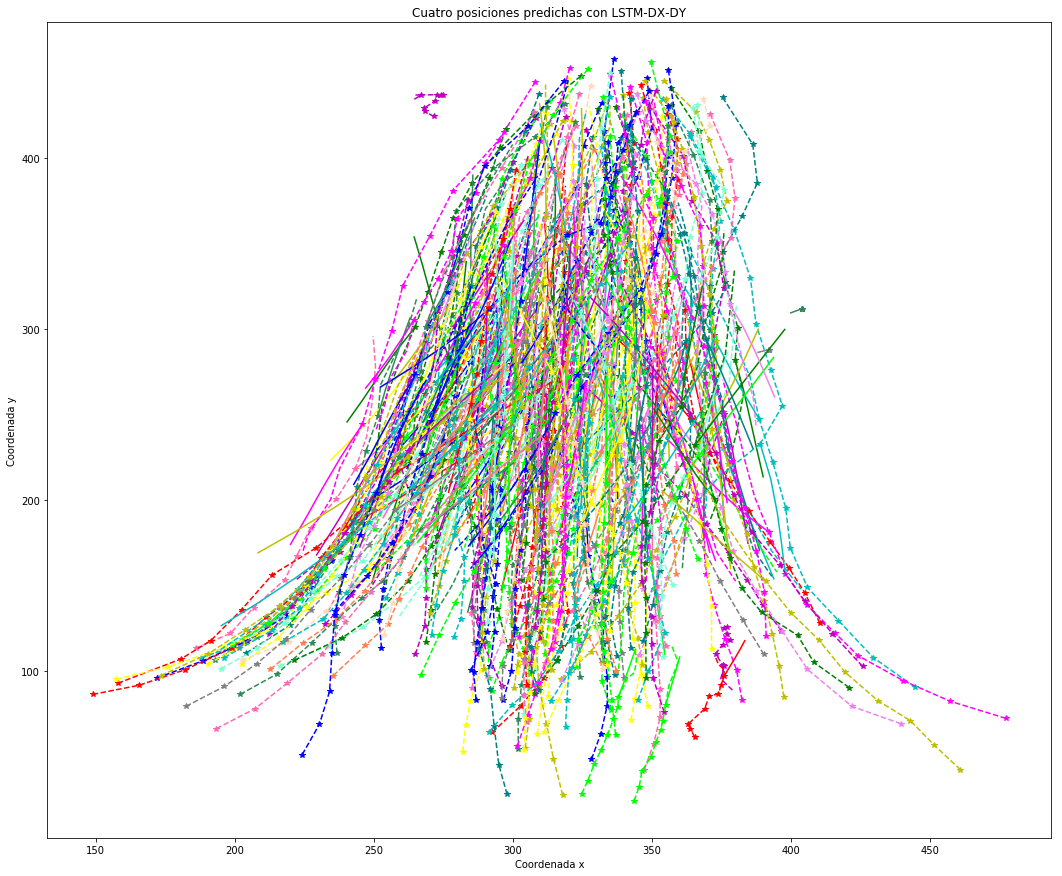

In [57]:
sample_x_persona(test,8,4)